In [1]:
#Import des lib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

I - Analyse 

       id  age  gender driving_experience    education         income  \
0  569520    3       0               0-9y  high school    upper class   
1  750365    0       1               0-9y         none        poverty   
2  199901    0       0               0-9y  high school  working class   
3  478866    0       1               0-9y   university  working class   
4  731664    1       1             10-19y         none  working class   

   credit_score  vehicle_ownership vehicle_year  married  children  \
0      0.629027                1.0   after 2015      0.0       1.0   
1      0.357757                0.0  before 2015      0.0       0.0   
2      0.493146                1.0  before 2015      0.0       0.0   
3      0.206013                1.0  before 2015      0.0       1.0   
4      0.388366                1.0  before 2015      0.0       0.0   

   postal_code  annual_mileage vehicle_type  speeding_violations  duis  \
0        10238         12000.0        sedan                    0  

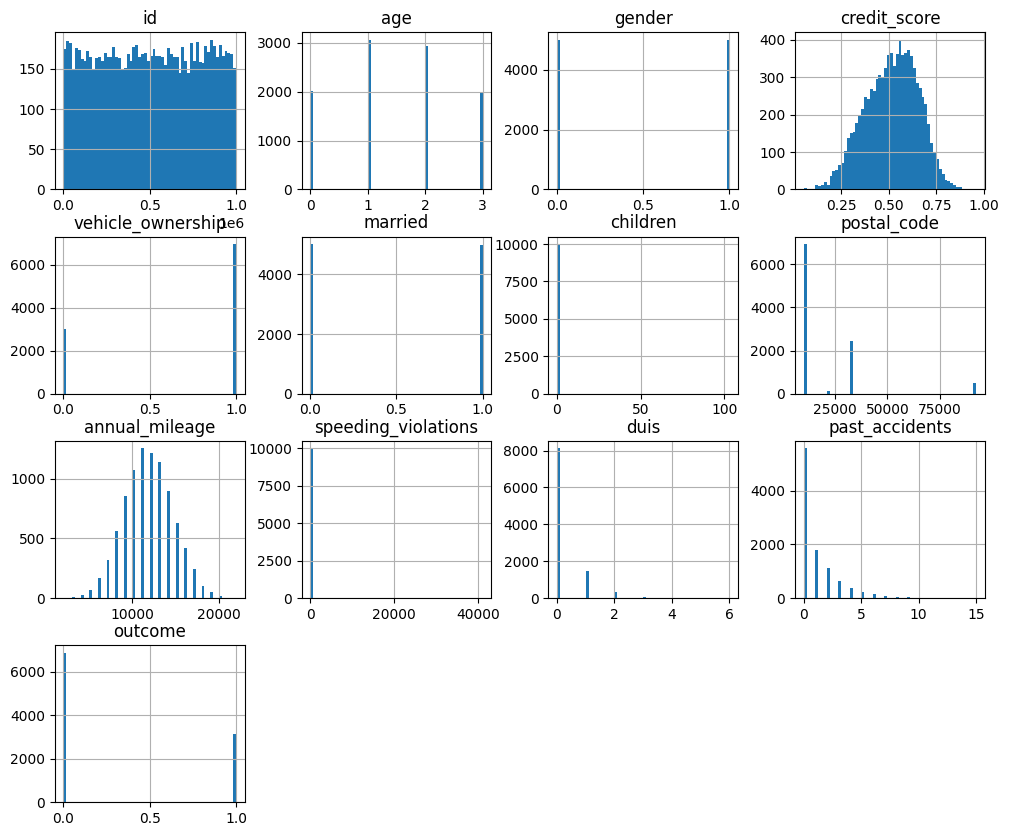

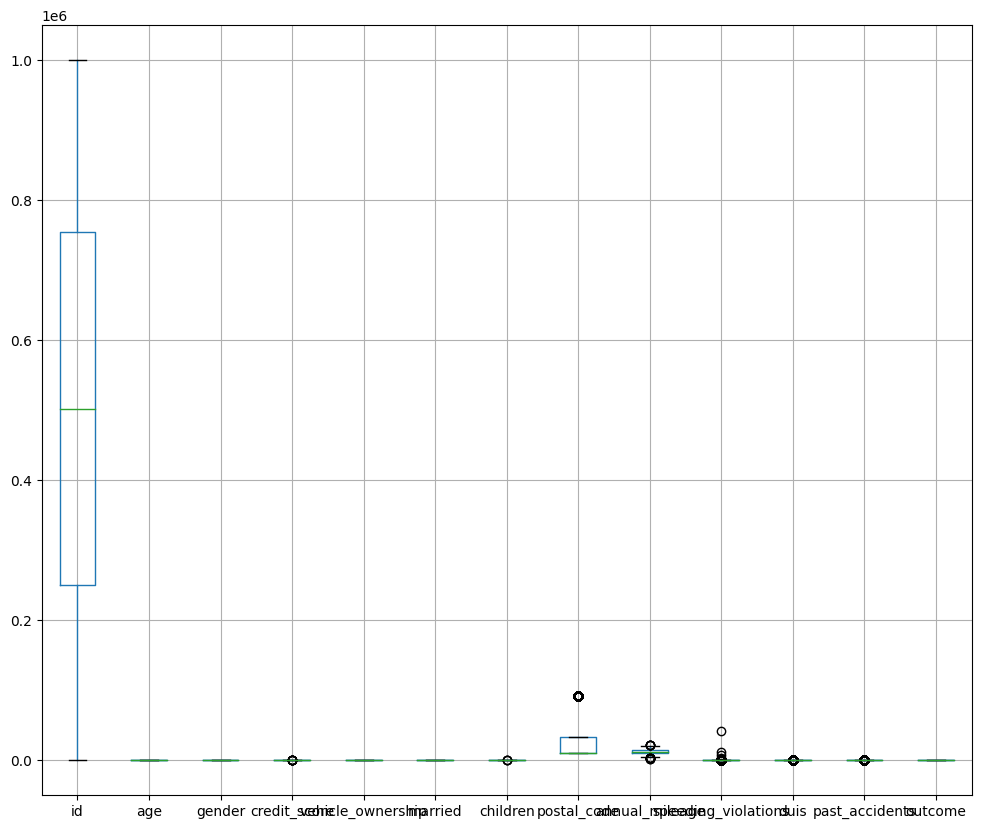

In [58]:
# Lecture du fichier CSV
df = pd.read_csv('car_insurance.csv')
# Affichage des premières lignes du DataFrame
print(df.head())

# Affichage des informations du DataFrame
print(df.info())

# Affichage des statistiques descriptives des données
print(df.describe())

# Comptage des valeurs manquantes
print(df.isna().sum())

# Histogrammes des variables numériques
df.hist(figsize=(12, 10),bins = 60)
plt.show()

# Boxplots pour détecter les valeurs aberrantes
df.boxplot(figsize=(12, 10))
plt.show()


II - Mise en forme 

In [61]:
    
def label_encode_columns(df, cols):
    df_copy = df.copy()
    label_encoder = LabelEncoder()
    for col in cols:
        df_copy[col] = label_encoder.fit_transform(df_copy[col])
    return df_copy

def preprocess_data(df):
    # Séparer les variables en numériques et catégorielles
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_cols.pop()
  
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Pipeline pour les variables numériques
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Imputation par la médiane
        ('scaler', StandardScaler())  # Normalisation des données
    ])

    # Transformer function for categorical columns
    categorical_transformer = Pipeline(steps=[
        ('label_encoder', FunctionTransformer(lambda df: label_encode_columns(df, categorical_cols), validate=False)),  # Encodage Label
        ('scaler', StandardScaler())  # Normalisation des données
    ])

    # Préprocesseur
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Préparation des données
    df_processed = pd.DataFrame(preprocessor.fit_transform(df))
    df_processed.columns = numerical_cols+categorical_cols
    df_outcome = pd.DataFrame(df['outcome'])

    df_processed = pd.concat([df_processed, df_outcome], axis=1)

    # Convert the result back to a DataFrame
    return df_processed

def threshold_cleaner(data,col, threshold):
     for i in range(data[col].shape[0]):
        if data[col][i] > threshold :
            data.loc[i, col] = None

def save_processed_data(df, filename):
    df.to_csv(filename, index=False)


# Chemin vers le fichier de données
data_path = 'car_insurance.csv'
processed_data_path = 'processed_car_insurance.csv'

# Charger et examiner les données
data = df = pd.read_csv(data_path)
data = data.drop('id',axis=1)

threshold_cleaner(data,'children',1)
threshold_cleaner(data,'speeding_violations',30)

# Préparer les données
processed_data = preprocess_data(data)


# Enregistrer les données transformées
save_processed_data(processed_data, processed_data_path)
print("sucessfully exported")


sucessfully exported


III - Training

In [ ]:
def split_data(df, test_size=0.2, random_state=42):
    X = df.drop('outcome', axis=1)
    y = df['outcome']
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_logistic_regression(X_train, y_train):
    # Paramètres pour la recherche de grille
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [200, 300, 500]
    }

    # Initialiser le modèle de régression logistique
    log_reg = LogisticRegression()

    # Initialiser GridSearchCV avec validation croisée
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Entraîner le modèle avec la recherche de grille
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters: {grid_search.best_params_}")

    # Retourner le meilleur modèle trouvé
    return grid_search.best_estimator_


#Chargement des données
data_path = 'processed_car_insurance.csv'
data = pd.read_csv(data_path)
# Id de la colonne outcome 
# target_column_index = data.shape[1]-1
X_train, X_test, y_train, y_test = split_data(data)

# Entraînement du modèle de régression logistique
logistic_model = train_logistic_regression(X_train, y_train)

# Évaluation du modèle
predictions = logistic_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

# Sauvegarde du modèle
joblib.dump(logistic_model, 'final_model.joblib')


IV - Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test): 
    
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    precision = precision_score(y_test, predictions, average='binary')
    recall = recall_score(y_test, predictions, average='binary')
    f1 = f1_score(y_test, predictions, average='binary')
    report = classification_report(y_test, predictions)

    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", report)

def perform_cross_validation(model, X, y):
    cross_validator = KFold(n_splits=5, shuffle=True, random_state=42)
    acc_scores = cross_val_score(model, X, y, cv=cross_validator, scoring='accuracy')
    print("Cross-Validation Scores:", acc_scores)
    print("Mean Accuracy:", acc_scores.mean())
    print("Standard Deviation:", acc_scores.std())

def analyze_correlations(df, target_column_index):
    corr_matrix = df.corr()
    print("\nCorrélations des variables :\n", corr_matrix)

    target_corr = corr_matrix.iloc[:, target_column_index].sort_values(ascending=False)
    print(f"\nCorrélations avec la variable cible à l'index {target_column_index} :\n", target_corr)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Heatmap des Corrélations')
    plt.show()

    scatter_matrix(df, figsize=(15, 15), diagonal='kde')
    plt.show()

# Chargement du modèle
model_path = 'final_model.joblib'
model = joblib.load(model_path)

# Évaluation du modèle sur les données de test
print("Évaluation sur le jeu de test :")
evaluate_model(model, X_test, y_test)


Training multi modèle

In [54]:
def train_best_model(X_train, y_train):
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(),
        'SVC': SVC(),
        'KNN': KNeighborsClassifier()
    }

    params = {
        'LogisticRegression': {'model__C': [0.1, 1, 10, 100]},
        'RandomForest': {'model__n_estimators': [10, 50, 100]},
        'SVC': {'model__C': [0.1, 1, 10], 'model__gamma': [0.001, 0.01, 0.1]},
        'KNN': {'model__n_neighbors': [3, 5, 7]}
    }

    best_models = {}
    for name, model in models.items():
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        grid_search = GridSearchCV(pipe, params[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"Best Parameters for {name}: {grid_search.best_params_}")

    return best_models

best_models = train_best_model(X_train, y_train)

model_names = ['LogisticRegression', 'RandomForest', 'SVC', 'KNN']
for model_name in model_names:
    model_path = f'final_model_{model_name}.joblib'

Best Parameters for LogisticRegression: {'model__C': 10}
Best Parameters for RandomForest: {'model__n_estimators': 50}
Best Parameters for SVC: {'model__C': 1, 'model__gamma': 0.01}
Best Parameters for KNN: {'model__n_neighbors': 5}


Evaluation de tout les modèle 

In [ ]:
for model_name in model_names:
    try:
        # Chargement du modèle
        model = joblib.load(model_path)
        # Évaluation du modèle sur les données de test
        print(f"\nÉvaluation sur le jeu de test pour le modèle {model_name} :")
        evaluate_model(model, X_test, y_test)
        # Validation croisée sur l'ensemble des données
        print(f"\nValidation croisée pour le modèle {model_name} :")
        perform_cross_validation(model, X_test, y_test)
    except FileNotFoundError:
        print(f"Modèle {model_name} non trouvé à {model_path}.")